In [48]:
import numpy as np
import gsd.hoomd
import multiprocessing as mp
import freud
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

In [49]:
s = np.array([179, 360, 542, 363, 473, 543])
r = np.array([None, None, 0.8, 0.7, 0.73, None])
tau_WT = np.array([])

In [50]:
N = 1000
def get_position(args):
    data, frame = args
    return data[frame].particles.position[:]

def load_conformations(gsd_file):
    with gsd_file as data:
        print('#data =', len(data))
        print(filename)
        with mp.Pool(processes=mp.cpu_count()) as pool:
            conf = pool.map(
                get_position,
                [(data, frame) for frame in range(len(data))]
                )
    return np.array(conf)
filename = f'data/trajectory_N{N}.gsd'
gsd_file = gsd.hoomd.open(name=filename, mode='r')

frames = load_conformations(gsd_file)

#data = 5000
data/trajectory_N1000.gsd


In [51]:
def compute_msd(trajectories):
    gsd_file = gsd.hoomd.open(name=filename, mode='r')
    Lx, Ly, Lz = gsd_file[0].configuration.box[0], gsd_file[0].configuration.box[1], gsd_file[0].configuration.box[2]
    box = freud.box.Box(Lx=Lx, Ly=Ly, Lz=Lz)
    msd = freud.msd.MSD(box=box, mode='window')
    print('computing MSD for')
    msd.compute(trajectories)
    return msd.msd

computing MSD for


/tmp/ipykernel_383091/1042240630.py:4: RuntimeWarning: divide by zero encountered in log
  x = np.log(np.arange(len(y)+1))[1:]


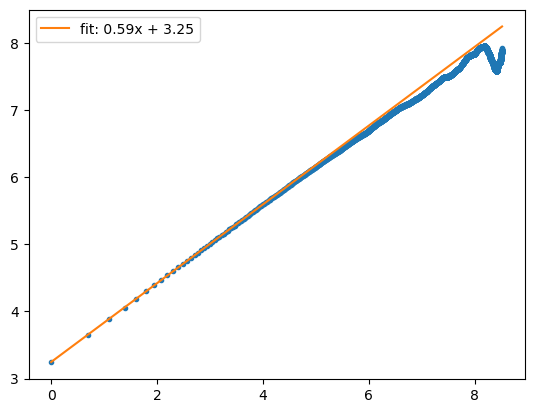

In [52]:
# single monomer MSD

y = np.log(compute_msd(frames))[1:]
x = np.log(np.arange(len(y)+1))[1:]

p,q = 0, 50

param, pcov = np.polyfit(x[p:q], y[p:q], 1, cov=True)
plt.plot(x,y, '.')
plt.plot(x, param[0]*x + param[1], label = f'fit: {param[0]:.2f}x + {param[1]:.2f}')

plt.legend()

# two locus  MSD

In [58]:
k = 300
N = frames.shape[1]

probe_position_1 = 50
probe_position_2 = 450
rij = np.array([(frames[:,i,:] - frames[:,i+k,:]) for i in np.linspace(k,N-k-1, (np.floor(N/k)).astype(int)).astype(int)])
rij = np.array([frames[:,probe_position_1,:] - frames[:,probe_position_2,:]]) 
print(rij.shape, k)
rij = np.swapaxes(np.array(rij), 0,1)
rij_k = (np.linalg.norm(rij, axis = -1)**2).mean(axis=0).mean()
MSD_two_k = compute_msd(rij)

(1, 5000, 3) 300
computing MSD for


In [59]:
rij_k

2497.972

In [60]:
rij_normalized = (rij/np.sqrt(rij_k))*0.7

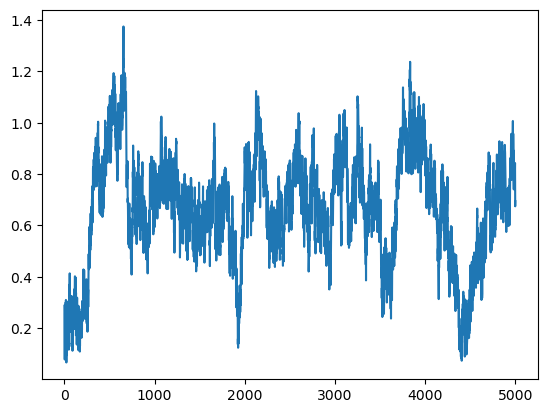

In [61]:
plt.plot(np.linalg.norm(rij_normalized[:,0,:], axis = -1))

/tmp/ipykernel_383091/562776364.py:9: RuntimeWarning: invalid value encountered in log
  y = np.log(MSD_two_k)[1:]
/tmp/ipykernel_383091/562776364.py:10: RuntimeWarning: divide by zero encountered in log
  x = np.log(np.arange(len(y)+1))[1:]
/tmp/ipykernel_383091/562776364.py:5: RuntimeWarning: invalid value encountered in sqrt
  term2 = 2 * J * erfc(np.sqrt(tau / (np.pi * t)))
/tmp/ipykernel_383091/562776364.py:18: OptimizeWarning: Covariance of the parameters could not be estimated
  param, pcov = curve_fit(M2, np.exp(x)[p:q], np.exp(y)[p:q], p0=[1, 200, 1])


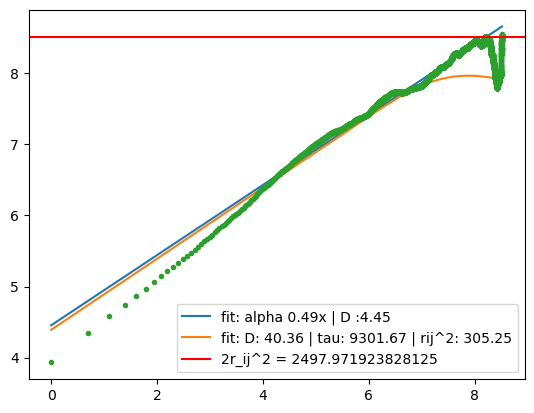

In [62]:

from scipy.special import erfc

def M2(t, gamma2, tau, J):
    term1 = 2 * gamma2 * np.sqrt(t) * (1 - np.exp(-tau / (np.pi * t)))
    term2 = 2 * J * erfc(np.sqrt(tau / (np.pi * t)))
    return term1 + term2


y = np.log(MSD_two_k)[1:]
x = np.log(np.arange(len(y)+1))[1:]

p,q = 0, 4000

param, pcov = np.polyfit(x[p:q], y[p:q], 1, cov=True)
plt.plot(x, param[0]*x + param[1], label = f'fit: alpha {param[0]:.2f}x | D :{param[1]:.2f}')

p,q = 0, 100
param, pcov = curve_fit(M2, np.exp(x)[p:q], np.exp(y)[p:q], p0=[1, 200, 1])
plt.plot(x, np.log(M2(np.exp(x), *param)), label = f'fit: D: {param[0]:.2f} | tau: {param[1]:.2f} | rij^2: {param[2]:.2f}')

plt.plot(x,y, '.')
plt.axhline(np.log(rij_k*2), color='r', label=f'2r_ij^2 = {rij_k}')
plt.legend()

In [ ]:
# 